In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.nn.functional import sigmoid
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


### Load data

In [6]:
# Load data
base_path = os.getcwd()
data_path = os.path.join(base_path, 'data')
filename = os.path.join(data_path, 'encoded_recipient_donor_op_comp_df.csv')

data = pd.read_csv(filename)

print(f"Total number of features (in_feature): {len(data.columns.drop(['CASEID', 'readm30daydc']))}\n")
print(f"Total number of patients: {len(data)}\n")
#print(data.columns)
#display(data.head())

Total number of features (in_feature): 134

Total number of patients: 2354



### Prepare data

In [4]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim: int = 56):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim,75),
            nn.ReLU(),
            nn.Linear(75,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32,1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x
    
scaler = StandardScaler()
X = data.drop(columns=['CASEID', 'readm30daydc']).values.astype(np.float32)
X = scaler.fit_transform(X)
y = data['readm30daydc'].values.astype(np.float32)

class_weight = torch.tensor([sum(y==0)/sum(y==1)])
print(class_weight)


tensor([3.0586], dtype=torch.float64)



==================== Fold 1 ====================
Epoch [2/10], Training Loss: 2.387 Validation Loss: 2.066
Epoch [10/10], Training Loss: 1.954 Validation Loss: 2.049
0.50334615 0.46293557 0.0052148104
Fold 1 AUROC: 0.61
Fold 1 Test Accuracy: 75.4%

==================== Fold 2 ====================
Epoch [2/10], Training Loss: 2.330 Validation Loss: 2.099
Epoch [10/10], Training Loss: 1.936 Validation Loss: 2.084
0.51082826 0.46607366 0.005472166
Fold 2 AUROC: 0.54
Fold 2 Test Accuracy: 75.4%

==================== Fold 3 ====================
Epoch [2/10], Training Loss: 2.063 Validation Loss: 2.130
Epoch [10/10], Training Loss: 1.688 Validation Loss: 2.091
0.5225877 0.4729622 0.006223996
Fold 3 AUROC: 0.61
Fold 3 Test Accuracy: 74.3%

==================== Fold 4 ====================
Epoch [2/10], Training Loss: 2.173 Validation Loss: 2.126
Epoch [10/10], Training Loss: 1.824 Validation Loss: 2.098
0.578674 0.4803556 0.0070143677
Fold 4 AUROC: 0.57
Fold 4 Test Accuracy: 72.2%

==========

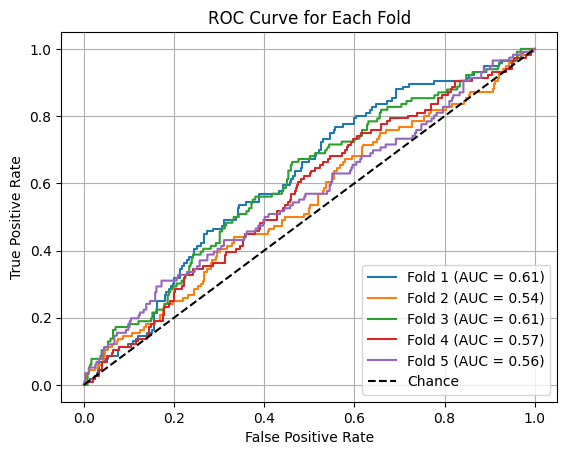

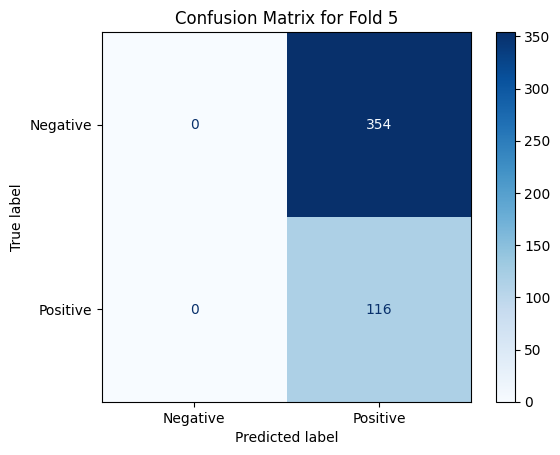

In [5]:
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_results = {}

for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):

    print(f'\n{"="*20} Fold {fold} {"="*20}')
    
    # Split data
    X_train_fold, X_test_fold = torch.tensor(X[train_index]), torch.tensor(X[test_index])
    y_train_fold, y_test_fold = torch.tensor(y[train_index]).unsqueeze(1), torch.tensor(y[test_index]).unsqueeze(1)
    
    # Initialize model
    in_features = X.shape[1]
    model = MLP(in_features)

    # Loss and optimizer
    # Use BCEWithLogitsLoss for numerical stability and apply class weights
    criterion = nn.BCELoss(weight=torch.tensor([3.0586]))
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.1, patience=5)

    # Training loop
    num_epochs = 10
    training_loss = []
    validation_loss = []

    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        outputs = model(X_train_fold)
        train_loss = criterion(outputs, y_train_fold)

        training_loss.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_fold)
            test_loss = criterion(outputs, y_test_fold)
            validation_loss.append(test_loss.item())

        if (epoch+1) % 10 == 0 or epoch == 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss.item():.3f} Validation Loss: {test_loss.item():.3f}")
        
        scheduler.step(test_loss)  # Pass validation loss to scheduler
    
    model.eval()
    with torch.no_grad():
        outputs = model(X_test_fold)
        loss = criterion(outputs, y_test_fold)
        y_prob = outputs.squeeze().numpy()
        print(max(y_prob), min(y_prob), np.std(y_prob))
        y_pred = (y_prob >= 0.5).astype(int)
        y_true = y_test_fold.squeeze().numpy().astype(int)

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"Fold {fold} AUROC: {roc_auc:.2f}")

    plt.plot(fpr,tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"Fold {fold} Test Accuracy: {accuracy*100:.1f}%")
    #print(y_pred)
    fold_results[fold] = {
        "accuracy": accuracy,
        "roc_auc": roc_auc
    }

# Plot the diagonal (chance line)
plt.plot([0, 1], [0, 1], 'k--', label="Chance")

# Configure plot
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Fold")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])  # Labels are optional for binary classification
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap='Blues')  # Customize the color map if needed
plt.title(f"Confusion Matrix for Fold {fold}")
plt.show()